In [55]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBT
from sklearn.decomposition import PCA
%matplotlib inline

#from sklearn.preprocessing import CategoricalEncoder
#CategoricalEncoder is part of sklearn's developer version, which you can't just update with conda. If you have issues
#getting this version, try a hard code implementation of the library here - https://pastebin.com/qs1es9XE

In [12]:
def transform_column(df, col, thresh=200):
    if df[col].nunique() > thresh:
        df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
        cat = [sorted(df_frequency[0:thresh].index.values)]
        dict2 = {}
        for i, item in enumerate(cat[0]):
            dict2[item] = i
        #enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
    else:
        dict2 = {}
        i = 0
        for item in df[col].values:
            if item not in dict2:
                dict2[item] = i
                i+=1
        #enc = CategoricalEncoder(categories='auto',handle_unknown='ignore')
    return [[1 if j == i else 0 for j in dict2] for i in df[col].values]

Our dataset appears to consist of two types of samples - bid samples, and ad samples. Since we are only trying to predict clicks on the ad, AKA "c_cnt", which only exists in ad samples, we will only be working with those data. Let's first parse the data and get what we need.

Parsing data from 12 hours.

In [3]:
hours = []
for i in range(12): 
    hours.append(pd.read_json("hour" + str(i) + ".json", lines=True))

Create a copy of the table as backup (in case original data gets corrupted)

In [4]:
table = pd.concat(hours)
safe_table = table.copy()
df = table

Now, we need to do some data cleaning. From some initial exploratory analysis, we can see that that we have 5 features with only 16 non-nan values, with a few other features having a similarly low level of non-nan values. To simplify things, we choose to drop all features with less than some threshhold of non-nan values. Also, as we are trying to predict c_cnt, samples where c_cnt is NaN are useless, so we throw those away as well. 

After this, we see that less than 10% of our remaining samples contains any NaN values, so we just drop those samples as we don't lose that much information from them.

In [5]:
#how many non-nan values do we have?
print(df.count())
n = len(df)

#filter rows with c_cnt as NaN
df = df[np.isfinite(df['c_cnt'])]

#filter threshhold
df = df.dropna(thresh=int(0.5*n), axis=1)
#drop all samples with NaN values
df = df.dropna(axis=0)

ad_network_id            1883983
ad_type                  1883983
advertiser_id            1883983
bid_requests             1883983
bid_responses            1883983
c_cnt                    1468618
c_timestamp                  914
c_txn_fee                    914
c_txn_rate                   914
campaign_id              1883983
campaign_type            1883983
cr_cnt                   1883983
creative_id              1883983
exp_mode                  427894
f_cnt                    1468618
geo_continent_code       1883983
geo_country_code2        1883983
geo_dma_code             1883983
geo_region_name          1838935
geo_timezone             1857314
i_cnt                    1468618
i_timestamp              1467727
pub_network_id           1883983
r_cnt                    1883983
r_num_ads_requested      1883983
r_num_ads_returned       1883983
r_num_ads_third_party    1883983
r_timestamp              1883983
rate_metric              1883983
session_id               1883983
site_id   

Now, we have some more preprocessing to do, so we wrote some simple functions for preprocessing. The most important thing we do here is that since most of our features are categorical, we must encode them with one-hot-encoding, which essentially turns one feature into n different features, one for each type of class in the original features. For example, if we had a feature for "hair color", we would map it to a higher dimensional feature space consisting of "is the hair white", "is the hair black", "is the hair brown", etc. Only one of these features would be a 1, and the rest would be 0.

Normally, each feature would be mapped to n features, with n being the number of unique classes that feature contains. For our data, however, some features will have thousands, even millions of unique classes, which would result is an omega-sparse dataset. To account for this, we set a threshhold at 200, such that n will never be greater than 201. We still keep track of the 200 most frequent classes, however, the rest will be bunched into a single class. The motivation for this is that for the more frequent classes, we have enough data that our ML models will be able to extract some information, but for the less frequent classes, there is too little data for accurate analysis, so we group them as one class.

In [6]:
#Turns a timestamp into which minute the time was at - used as a categorical feature.
def timestamp_to_min(timestamp, is_hour=True):
    if is_hour:
        return timestamp.split(':')[0][-2:]
    else: 
        return timestamp.split(':')[1]

#plots frequency of a feature's different classes, useful for exploratory analysis
def plot_freq(col_name, df):
    df_frequency = df.groupby(col_name).agg('count').sort_values('ad_type',ascending=False)
    plt.plot([i for i in range(len(df_frequency.values))], [np.log(i[2]) for i in df_frequency.values])
    plt.show()

#if a feature only has one unique value, it tells us nothing, so we drop it.
def remove_only_ones(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col, inplace=True,axis=1)

#just prints how many unique values are in each feature
def print_column_counts(df):    
    for i in df:
        print(i, df[i].nunique())

#We do some final cleaning, changing all non-numerical features into strings for later.
def preprocess(df):    
    for i in df:
        if i[-1] != 't' or i[-2] != 'n' or i[-3] != 'c':
            df[i] = df[i].astype('str')
    remove_only_ones(df)
    if 'site_id' in df.columns:
        df.drop('site_id',inplace=True,axis=1)
    df['i_timestamp'] = df['i_timestamp'].apply(timestamp_to_min)
    df['r_timestamp'] = df['r_timestamp'].apply(timestamp_to_min)
    


#final preprocessing
preprocess(df)
#this set contains our numerical column names
numerical_features = set(['c_cnt', 'i_cnt', 'r_cnt', 'vi_cnt'])
#we create a copy so that X will not include 'c_cnt'
df2 = df.copy()
df2.drop('c_cnt',inplace=True,axis=1)
#u,s,v = np.linalg.svd(X)

#given a categorical column, we apply our earlier strategy of one-hot-encoding with maximum thresh=200
def transform_column(df, col, thresh=200, return_labels=False):
    print(col)
    df_frequency = df[[col, 'c_cnt']].groupby(col).agg('count').sort_values('c_cnt',ascending=False)
    if df[col].nunique() > thresh:
        enc = CategoricalEncoder(categories=[sorted(df_frequency[0:thresh].index.values)],handle_unknown='ignore')
        labels = df_frequency[0:thresh].index.values
    else:
        enc = CategoricalEncoder(categories=[sorted(df_frequency.index.values)],handle_unknown='ignore')
        labels = df_frequency.index.values
    labels = [str(col) + str(i) for i in labels]
    if return_labels:
        return labels
    enc.fit(df[col].values.reshape(-1, 1))
    return enc.transform(df[col].values.reshape(-1,1)).toarray()

Create our X and Y matrices - adjust threshhold values for 1HE here

In [13]:
one_hot_thresh = 20
Y = df['c_cnt'].values
X = np.hstack([transform_column(df, col, thresh=one_hot_thresh) if col not in numerical_features else df[col].values.reshape(-1,1)
               for col in df2])

Now we split the data into 2 sets: training and testing to avoid overfitting of the model. This is done before any subsampling to avoid contaminating the test set. The train set is now subsampled to increase ratio of clicks to nonclicks from 1:2000 to 1:3 which allows models to more accurately learn the click patterns

In [14]:
def fix_class_imbalance_with_subsampling(tempX, tempY, pos_ratio=2):
    tempY = tempY.reshape(-1,1)
    ind_1, ind_0 = [], []
    for i, y_h in enumerate(tempY):
        if y_h: ind_1.append(i)
        else: ind_0.append(i)
    to_sample = np.random.permutation(pos_ratio*len(ind_1))
    to_sample_0 = [ind_0[i] for i in to_sample]
    X2 = np.vstack([tempX[ind_1],tempX[to_sample_0]])
    Y2 = np.vstack([tempY[ind_1],tempY[to_sample_0]])
    tempY = tempY.reshape(-1)
    
    new_ind = np.random.permutation(len(X2))
    return X2[new_ind],Y2[new_ind]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3)

X_fix , Y_fix = fix_class_imbalance_with_subsampling(X_train, y_train, pos_ratio=3)
Y_fix=Y_fix.ravel()


Custom training score for various paramters - Inverse of Euclidian Distance: Rewards both higher and less "extreme" values. Uses Precision of training as X and Recall as Y. 

In [37]:
def score(y_pred , y_test):
    test = confusion_matrix(y_test , y_pred)
    prec = test[1][1] / (test[1][1] + test[0][1])
    rec = test[1][1] / (test[1][1] + test[1][0])
    print("Precision: ", prec)
    print("Recall" , rec)
    return ((prec ** 0.5) * (rec ** 0.5))**2

Run PCA to condense the data to 80% of it's variance, but cut the featuers from 350 -> 30. This allows it to train faster later

In [47]:
pca = PCA(n_components = 0.8)
pca.fit(X_train)
X_train_small = pca.transform(X_train)
X_test_small = pca.transform(X_test)

Run a search across all possible paramters for RF in order to find one that maximizes score.

In [64]:


weight = {0:1 , 1:1}

scores = []

for max_feat in ["auto" , "log2",  10 , 30 , 50]:
    n_s = []
    for n_est in [1 , 10 ,50 ,100]:
        mdl = RFC(max_features = max_feat, n_estimators = n_est , class_weight = weight)
        mdl.fit(X_fix , Y_fix)
        y_pred = mdl.predict(X_test)
        fs = f1_score(y_test,y_pred)
        #print(fs)
        n_s.append(fs)
        score(y_pred , y_test)
       # n_s.append(score(y_pred , y_test))
    scores.append(n_s)












Precision:  0.00288352674781
Recall 0.634241245136
Precision:  0.0048107495369
Recall 0.677042801556
Precision:  0.00476293570037
Recall 0.684824902724
Precision:  0.00481413605405
Recall 0.684824902724
Precision:  0.00289504965681
Recall 0.587548638132
Precision:  0.00486558812796
Recall 0.622568093385
Precision:  0.00491421190082
Recall 0.68093385214
Precision:  0.00496485551713
Recall 0.692607003891
Precision:  0.00298049294141
Recall 0.649805447471
Precision:  0.00533796974134
Recall 0.68093385214
Precision:  0.00483965176759
Recall 0.677042801556
Precision:  0.00473738978038
Recall 0.673151750973
Precision:  0.0024479252707
Recall 0.634241245136
Precision:  0.00506781934715
Recall 0.661478599222
Precision:  0.00472736164317
Recall 0.677042801556
Precision:  0.00475000686417
Recall 0.673151750973
Precision:  0.00303744997141
Recall 0.661478599222
Precision:  0.00464252553389
Recall 0.642023346304
Precision:  0.00481277766025
Recall 0.708171206226
Precision:  0.0047412300562
Recall 

Plot the number of estimators (1,10 ,50 ,100) on the x-axis vs number of maximum number of features in a given tree (sqrt , lg2 , 10 , 30 , 50) : y-axis, in a heat map format to see which features provide highest accuracy. Use F1 metric to score models

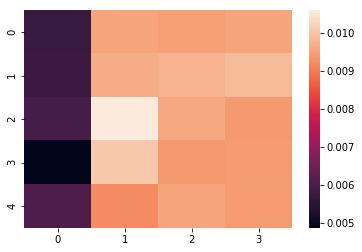

In [65]:
sns.heatmap(scores)

Looks like lg2 features did the most consistently and 50 estimators did the best. So use these for next grid search

Notes for reading confusion matrix

[0][0] correct non-clicked
[1][0] - Incorrect - ACTUALLY CLICK
[0][1] - Inccroect  - ACTUALLY NONCLICK
[1][1] - correct click


Do another grid search on Weighting and Max_depth. Trying to see if weighting the positive class will increase precision from last classifcation.

In [69]:


weight = {0:1 , 1:1}

scores = []

for weights in [0.001 , 0.1, 1,10,100,1000]:
    n_s = []
    for max_depths  in [1 , 10 , 100]:
        weight = {0:1 , 1:weights}
        mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = weight , max_depth= max_depths)
        mdl.fit(X_fix , Y_fix)
        y_pred = mdl.predict(X_test)
        fs = f1_score(y_test,y_pred)
        #print(fs)
        n_s.append(fs)
        score(y_pred , y_test)
       # n_s.append(score(y_pred , y_test))
    scores.append(n_s)












C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Precision:  nan
Recall 0.0
Precision:  0.0170212765957
Recall 0.0155642023346
Precision:  0.00499873627454
Recall 0.692607003891


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in longlong_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Precision:  nan
Recall 0.0
Precision:  0.0078125
Recall 0.105058365759
Precision:  0.0048440554092
Recall 0.665369649805
Precision:  0.0136612021858
Recall 0.0194552529183
Precision:  0.00740667588386
Recall 0.583657587549
Precision:  0.00485080940831
Recall 0.669260700389
Precision:  0.000596870725233
Recall 1.0
Precision:  0.00222275956996
Recall 0.929961089494
Precision:  0.00487977754757
Recall 0.696498054475
Precision:  0.000596870725233
Recall 1.0
Precision:  0.000604458409969
Recall 1.0
Precision:  0.00504574438592
Recall 0.708171206226
Precision:  0.000596870725233
Recall 1.0
Precision:  0.0006015917603
Recall 1.0
Precision:  0.00497582368155
Recall 0.688715953307


Heat map with weighting for positive class on y  [0.001 , 0.1, 1,10,100,1000] and max depth on X [1 , 10 , 100]. 

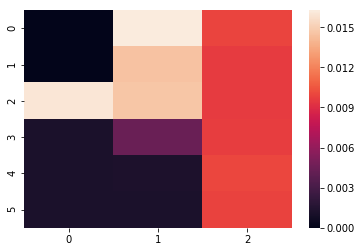

In [70]:
sns.heatmap(scores)

Best performace currently: max_features = "log2", n_estimators = 50 , class_weight: 0:1 , 1:0.001 , max_depth= 10)

In [82]:
mdl = RFC(max_features = "log2", n_estimators = 50 , class_weight = {0:1 , 1:1.5} , max_depth= 1)
mdl.fit(X_fix , Y_fix)
y_pred = mdl.predict(X_test)
score(y_pred , y_test)

Precision:  0.00721175516091
Recall 0.311284046693


0.0022449043302450707

Unfortunetly still has very poor performance on all paramters - need to work on feature selection to improve model.